# Week 02 — Support Vector Machines (SVM)

## Goal:
Train and compare **linear vs kernel SVM** models on a binary classification dataset, and tune key hyperparameters.

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

os.makedirs("../images", exist_ok=True)

In [7]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

print("X shape:", X.shape)
print("Classes:", data.target_names)
print("Class distribution:", y.value_counts().to_dict())
display(X.head())

X shape: (569, 30)
Classes: ['malignant' 'benign']
Class distribution: {1: 357, 0: 212}


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train distribution:", y_train.value_counts().to_dict())

Train: (455, 30) Test: (114, 30)
Train distribution: {1: 285, 0: 170}


,Kernel,Accuracy
1,RBF,0.982456
0,Linear,0.973684
2,Poly(d=3),0.912281


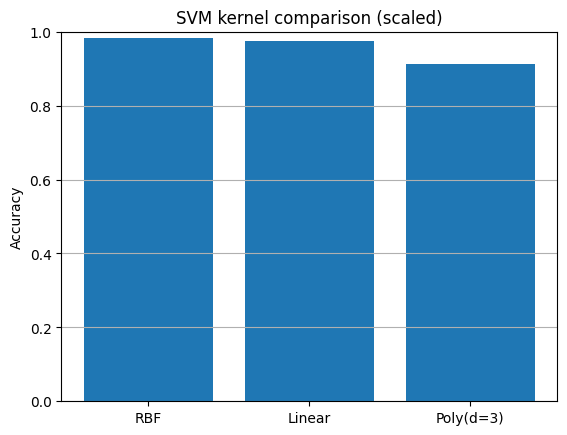

In [9]:
def fit_eval(name, svc):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", svc)
    ])
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    return name, model, acc

c_value = 1.0

candidates = [
    ("Linear", SVC(kernel="linear", C=c_value)),
    ("RBF",    SVC(kernel="rbf", C=c_value, gamma="scale")),
    ("Poly(d=3)", SVC(kernel="poly", C=c_value, degree=3, gamma="scale"))
]

results = []
models = {}

for name, svc in candidates:
    name, model, acc = fit_eval(name, svc)
    results.append((name, acc))
    models[name] = model

results_df = pd.DataFrame(results, columns=["Kernel", "Accuracy"]).sort_values("Accuracy", ascending=False)
display(results_df)

plt.figure()
plt.bar(results_df["Kernel"], results_df["Accuracy"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("SVM kernel comparison (scaled)")
plt.grid(axis="y")
plt.savefig("../images/week02_svm_kernel_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

In [10]:
Cs = [0.1, 1, 10]
gammas = [0.01, 0.1, 1]

tuning = []
best_name, best_model, best_acc = None, None, -1

for C in Cs:
    for g in gammas:
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(kernel="rbf", C=C, gamma=g))
        ])
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        acc = accuracy_score(y_test, pred)
        tuning.append((C, g, acc))

        if acc > best_acc:
            best_acc = acc
            best_name = f"RBF(C={C}, gamma={g})"
            best_model = model

tuning_df = pd.DataFrame(tuning, columns=["C", "gamma", "Accuracy"]).sort_values("Accuracy", ascending=False)
display(tuning_df.head(10))

tuning_df.to_csv("../images/week02_svm_rbf_tuning_table.csv", index=False)
print("Best:", best_name, "acc=", best_acc)
print("Saved tuning table -> ../images/week02_svm_rbf_tuning_table.csv")

,C,gamma,Accuracy
3,1.0,0.01,0.982456
6,10.0,0.01,0.982456
0,0.1,0.01,0.956140
4,1.0,0.10,0.956140
1,0.1,0.10,0.947368
7,10.0,0.10,0.947368
2,0.1,1.00,0.631579
5,1.0,1.00,0.631579
8,10.0,1.00,0.631579


Best: RBF(C=1, gamma=0.01) acc= 0.9824561403508771
Saved tuning table -> ../images/week02_svm_rbf_tuning_table.csv


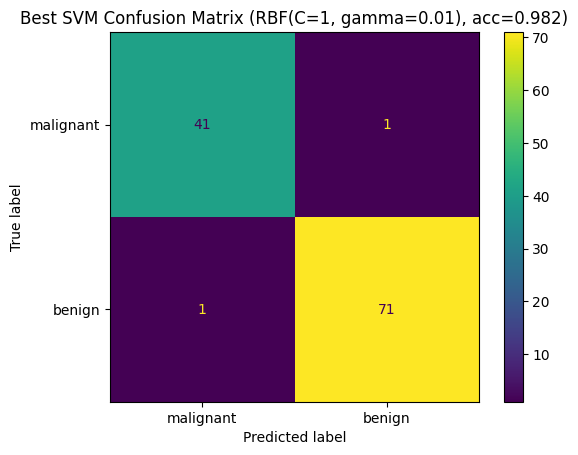

              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [11]:
pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.target_names)
disp.plot()
plt.title(f"Best SVM Confusion Matrix ({best_name}, acc={best_acc:.3f})")
plt.savefig("../images/week02_svm_confusion_matrix.png", dpi=200, bbox_inches="tight")
plt.show()

print(classification_report(y_test, pred_best, target_names=data.target_names))